# cCRE Analysis HG38

Creates boxplot for cCRE enrichment analysis across all HGSVC Haplotypes
cCRE ANnotations taken from SCREEN ENCODE DATABASE

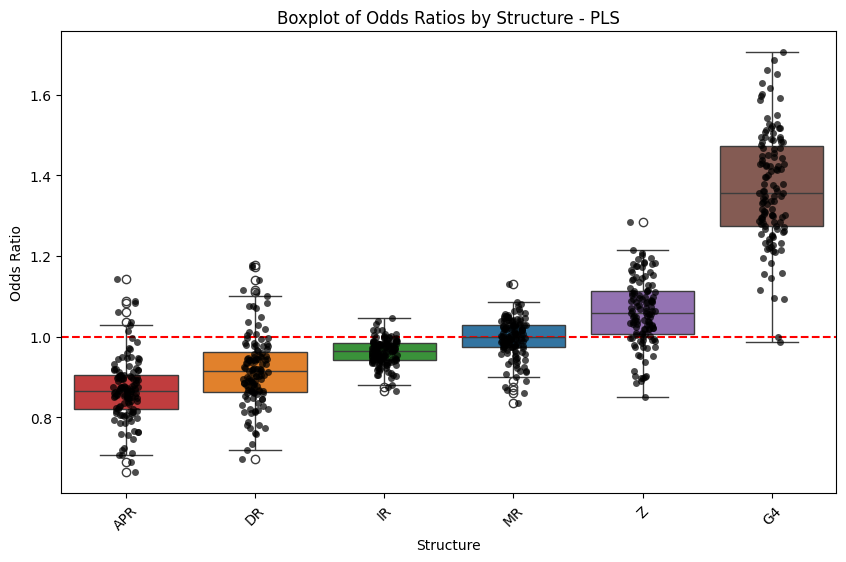

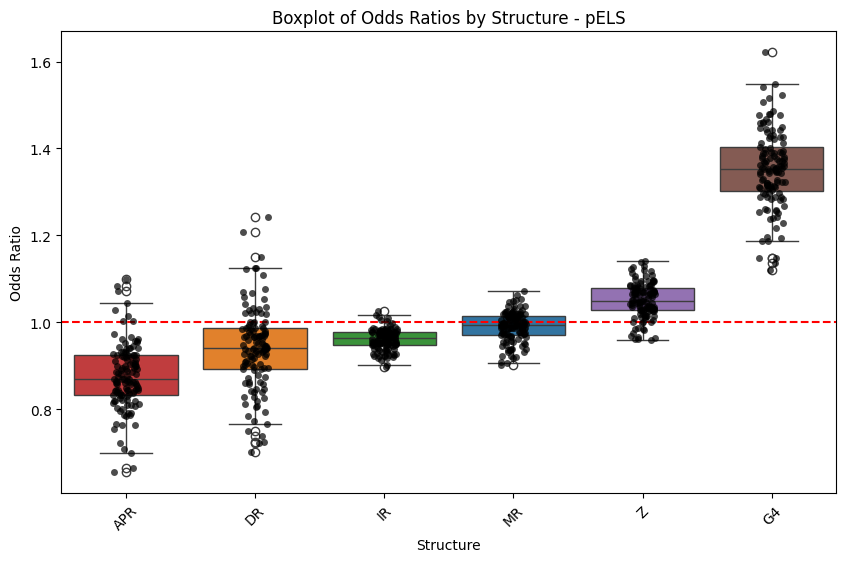

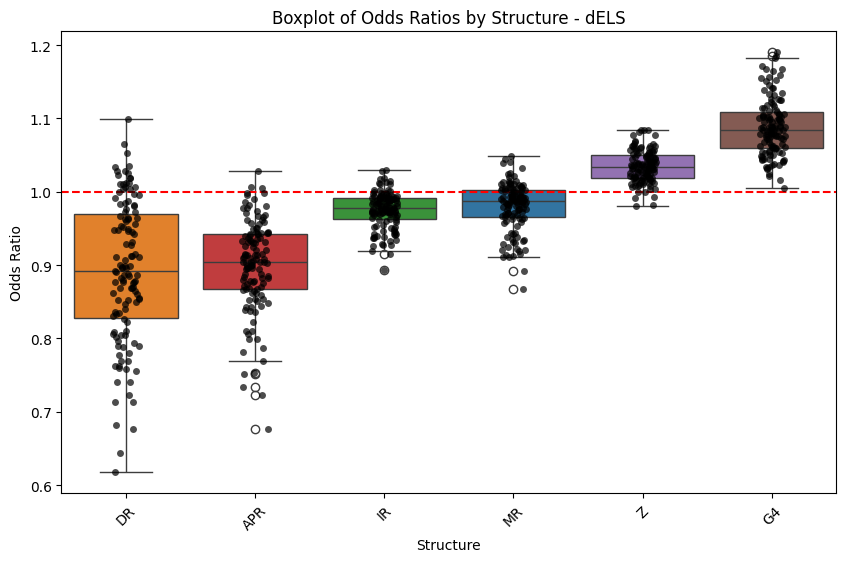

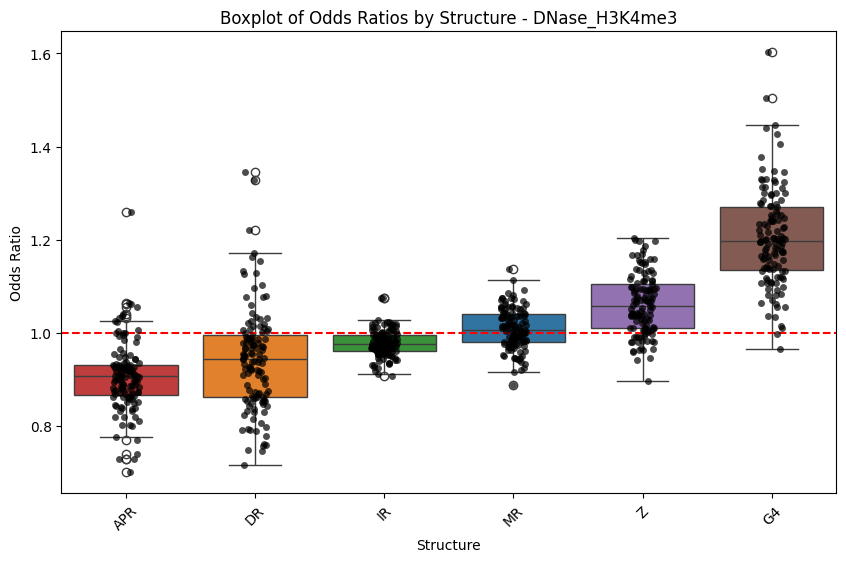

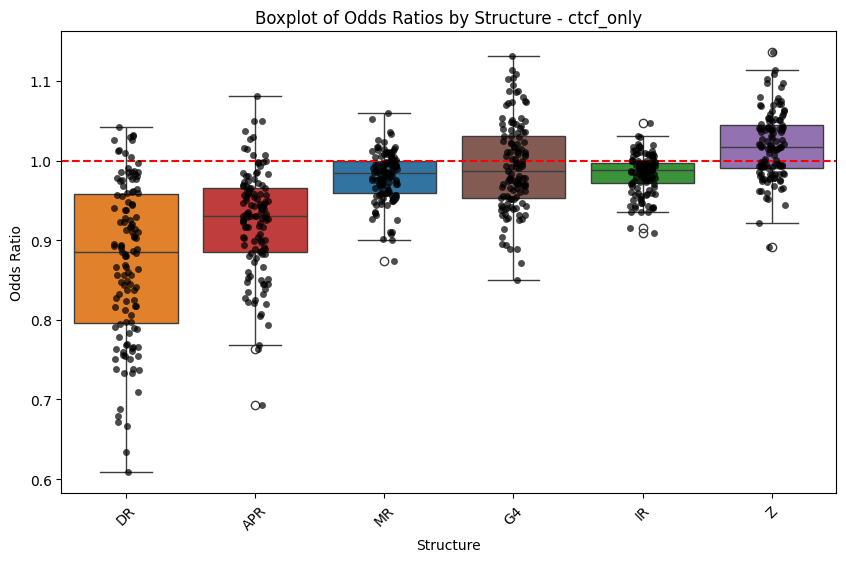

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Directory where the files are stored
directory = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/cCRE_analysis/"  # Change this to your actual directory

# List of file names
file_names = [
    "final_results_PLS.csv",
    "final_results_pELS.csv",
    "final_results_dELS.csv",
    "final_results_DNase_H3K4me3.csv",
    "final_results_ctcf_only.csv"
]

# Iterate over each file
for file in file_names:
    file_path = os.path.join(directory, file)

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue  # Skip to the next file if not found

    # Extract regulatory element name from file name
    regulatory_element = file.replace("final_results_", "").replace(".csv", "")

    # Load the data
    df = pd.read_csv(file_path)

    # Ensure the required columns exist
    if "structure" not in df.columns or "odds_ratio" not in df.columns:
        print(f"Skipping {file}: Required columns missing.")
        continue

    # Sort structures by median odds_ratio
    median_order = df.groupby("structure")["odds_ratio"].median().sort_values().index

    # Create the boxplot with a distinct color for each structure
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="structure", y="odds_ratio", data=df, order=median_order, hue="structure", legend=False)

    # Overlay individual points
    sns.stripplot(x="structure", y="odds_ratio", data=df, order=median_order, color='black', size=5, jitter=True, alpha=0.7)

    # Add horizontal line at odds ratio = 1
    plt.axhline(y=1, color='red', linestyle='--', linewidth=1.5)

    # Formatting
    plt.xticks(rotation=45)
    plt.xlabel("Structure")
    plt.ylabel("Odds Ratio")
    plt.title(f"Boxplot of Odds Ratios by Structure - {regulatory_element}")

    # Show plot
    plt.show()

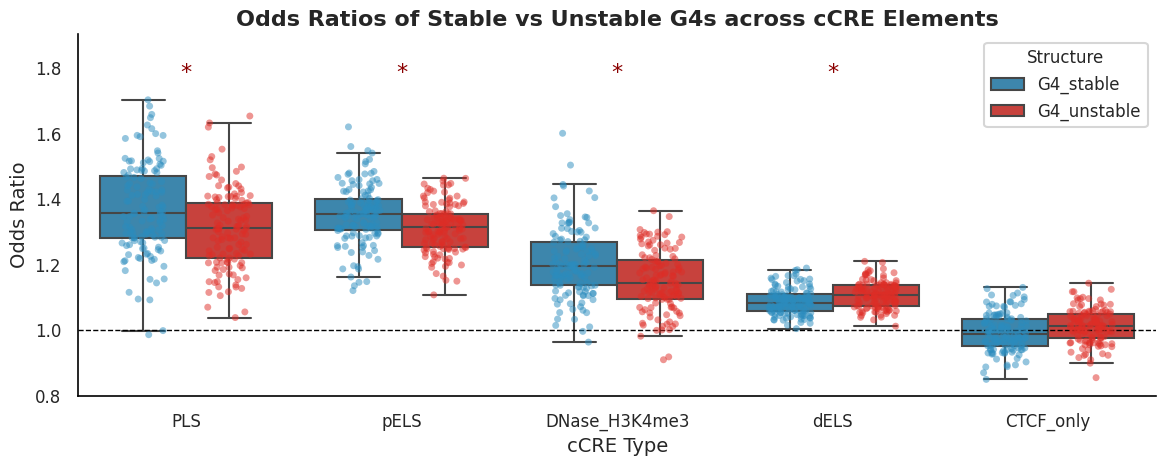

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import mannwhitneyu
import numpy as np

# === Set custom style for publication ===
sns.set_context("talk")  # larger font sizes
sns.set_style("white")   # white background, no grid
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

# === Directory where your files are stored ===
data_dir = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/cCRE_analysis/results_wholegenome_allQs/"
files = glob.glob(os.path.join(data_dir, "final_results_G4_stable_vs_unstable_*.csv"))

# === Extract cCRE type from filename ===
def get_ccre_type(filename):
    base = os.path.basename(filename)
    return base.replace("final_results_G4_stable_vs_unstable_", "").replace(".csv", "")

# === Load and combine ===
dfs = []
for f in files:
    df = pd.read_csv(f)
    df['ccre'] = get_ccre_type(f)
    dfs.append(df)
combined = pd.concat(dfs)

# === Pivot and melt ===
pivoted = combined.pivot_table(index=['sample_hap', 'ccre'], columns='structure', values='odds_ratio').reset_index()
melted = pd.melt(pivoted, id_vars=['sample_hap', 'ccre'], value_vars=['G4_stable', 'G4_unstable'],
                 var_name='structure', value_name='odds_ratio')

# === Sort cCREs by G4_stable median ===
order = (
    melted[melted['structure'] == 'G4_stable']
    .groupby('ccre')['odds_ratio']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# === Mann-Whitney U testing ===
raw_pvals = []
tested_ccres = []
for ccre in order:
    group = melted[melted['ccre'] == ccre]
    stable = group[group['structure'] == 'G4_stable']['odds_ratio']
    unstable = group[group['structure'] == 'G4_unstable']['odds_ratio']
    if len(stable) > 1 and len(unstable) > 1:
        stat, p = mannwhitneyu(stable, unstable, alternative='two-sided')
    else:
        p = 1.0
    raw_pvals.append(p)
    tested_ccres.append(ccre)

# === Bonferroni correction ===
raw_pvals = np.array(raw_pvals)
bonferroni_pvals = np.clip(raw_pvals * len(raw_pvals), 0, 1)
pval_dict = dict(zip(tested_ccres, bonferroni_pvals))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 5))

# Custom, elegant colors
custom_palette = {
    "G4_stable": "#2b8cbe",    # Blue
    "G4_unstable": "#de2d26"   # Red
}

sns.boxplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
            palette=custom_palette, showfliers=False, order=order, ax=ax, linewidth=1.5)

sns.stripplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
              dodge=True, palette=custom_palette, alpha=0.5, size=5, jitter=0.2,
              order=order, ax=ax, legend=False)

# Reference line
ax.axhline(1, color='black', linestyle='--', linewidth=1)

# Axis labels and title
ax.set_title("Odds Ratios of Stable vs Unstable G4s across cCRE Elements", fontsize=16, weight='bold')
ax.set_ylabel("Odds Ratio", fontsize=14)
ax.set_xlabel("cCRE Type", fontsize=14)
ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=12)
# Clean up x-axis ticks
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2], labels=labels[:2], title='Structure', title_fontsize=12, fontsize=12, loc='upper right')

# Add significance markers
y_max = melted['odds_ratio'].max()
for i, ccre in enumerate(order):
    if pval_dict.get(ccre, 1.0) < 0.01:
        ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='darkred')

ax.set_ylim(top=y_max + 0.2)
sns.despine()

plt.tight_layout()
plt.savefig('G4_OR_stability_ccre.pdf', bbox_inches='tight')
plt.show()

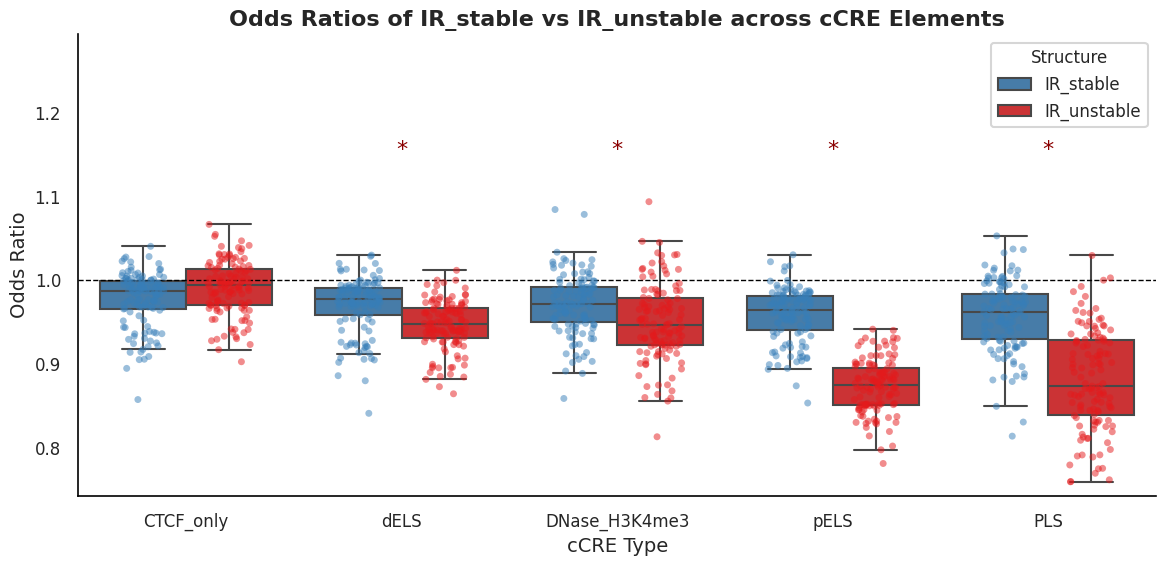

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import mannwhitneyu
import numpy as np

# === Set seaborn style for publication ===
sns.set_context("talk")  # larger fonts
sns.set_style("white")   # no gridlines
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

# === Directory containing IR odds ratio result files ===
data_dir = "/home/alextu/scratch/cCRE_analysis/results_IRs_free_energy/"
files = glob.glob(os.path.join(data_dir, "final_results_IR_stable_vs_unstable_*.csv"))

# === Extract cCRE type from filename ===
def get_ccre_type(filename):
    base = os.path.basename(filename)
    return base.replace("final_results_IR_stable_vs_unstable_", "").replace(".csv", "")

# === Load and combine ===
dfs = []
for f in files:
    df = pd.read_csv(f)
    df['ccre'] = get_ccre_type(f)
    dfs.append(df)
combined = pd.concat(dfs)

# === Pivot and melt for plotting ===
pivoted = combined.pivot_table(index=['sample_hap', 'ccre'], columns='structure', values='odds_ratio').reset_index()
melted = pd.melt(pivoted, id_vars=['sample_hap', 'ccre'], value_vars=['IR_stable', 'IR_unstable'],
                 var_name='structure', value_name='odds_ratio')

# === Sort cCREs by IR_stable median ===
order = (
    melted[melted['structure'] == 'IR_stable']
    .groupby('ccre')['odds_ratio']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# === Mann–Whitney U tests ===
raw_pvals = []
tested_ccres = []

for ccre in order:
    group = melted[melted['ccre'] == ccre]
    stable = group[group['structure'] == 'IR_stable']['odds_ratio']
    unstable = group[group['structure'] == 'IR_unstable']['odds_ratio']
    if len(stable) > 1 and len(unstable) > 1:
        stat, p = mannwhitneyu(stable, unstable, alternative='two-sided')
    else:
        p = 1.0
    raw_pvals.append(p)
    tested_ccres.append(ccre)

# === Bonferroni correction ===
raw_pvals = np.array(raw_pvals)
bonferroni_pvals = np.clip(raw_pvals * len(raw_pvals), 0, 1)
pval_dict = dict(zip(tested_ccres, bonferroni_pvals))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 6))

# Custom publication-style color palette
custom_palette = {
    "IR_stable": "#377eb8",    # Blue
    "IR_unstable": "#e41a1c"   # Red
}

sns.boxplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
            palette=custom_palette, showfliers=False, order=order, ax=ax, linewidth=1.5)

sns.stripplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
              dodge=True, palette=custom_palette, alpha=0.5, size=5, jitter=0.2,
              order=order, ax=ax, legend=False)

# Reference line
ax.axhline(1, color='black', linestyle='--', linewidth=1)

# Axis labels and title
ax.set_title("Odds Ratios of IR_stable vs IR_unstable across cCRE Elements", fontsize=16, weight='bold')
ax.set_ylabel("Odds Ratio", fontsize=14)
ax.set_xlabel("cCRE Type", fontsize=14)

# Rotate x-tick labels safely
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:2], labels=labels[:2], title='Structure', title_fontsize=12, fontsize=12, loc='upper right')

# Add significance stars
y_max = melted['odds_ratio'].max()
for i, ccre in enumerate(order):
    if pval_dict.get(ccre, 1.0) < 0.01:
        ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='darkred')

ax.set_ylim(top=y_max + 0.2)
sns.despine()

plt.tight_layout()
plt.savefig('IR_OR_stability_ccre.pdf', bbox_inches='tight')
plt.show()

Number of IRs in p21 promoter: 20
Average free energy: -4.66 kcal/mol
Min free energy: -26.90 kcal/mol
Max free energy: 0.60 kcal/mol
Median free energy: -3.30 kcal/mol

Top 5 most stable IRs (lowest free energy):
            Start      Stop  Free_Energy  \
5143471  36678147  36678248        -26.9   
5143474  36678610  36678640        -13.2   
5143475  36678736  36678773        -12.9   
5143466  36676142  36676159         -5.4   
5143472  36678280  36678293         -4.6   

                                                  Sequence  
5143471  ccgccgccggccccgctgggggcttggctcacttccccagagcggc...  
5143474                    ccccgggcggtcctcgcgcccccgcccgggg  
5143475             gggcggggccacttctcactgtcgcgcaggccccgccc  
5143466                                 atgtttgaaaacaaacat  
5143472                                     gcgcaggcctgcgc  


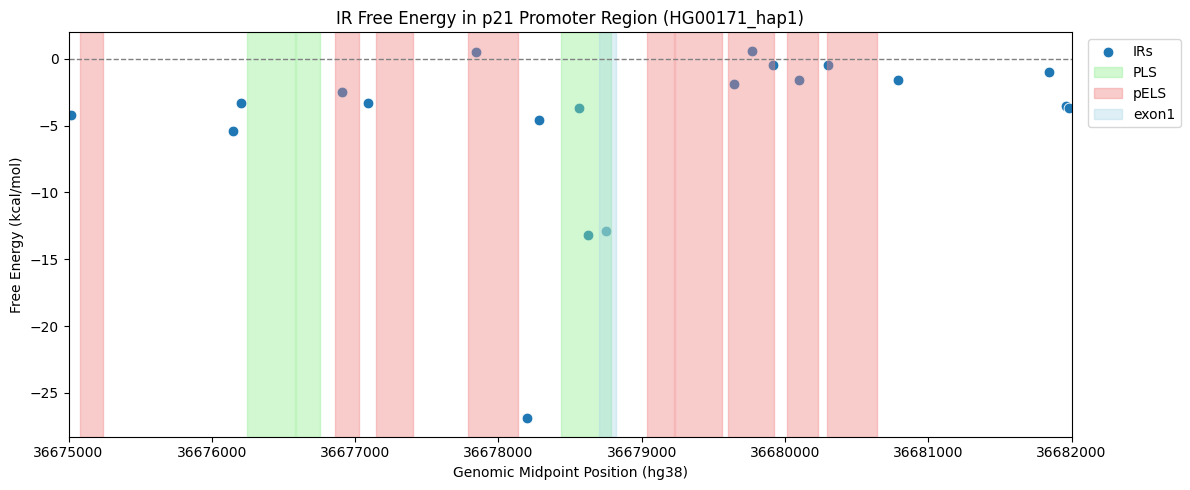

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === File and region settings ===
file_path = "/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00171_hap1_IR_free_energy.tsv"
annotation_file = "/home/alextu/scratch/Biological regions  aggregate  NCBI RefSeq Annotation GCF_000001405.40-RS_2024_08.BED"
target_chr = "chr6"
target_start = 36675000
target_end = 36682000

# === Load and filter IR data ===
df = pd.read_csv(file_path, sep="\t")
df["chrom"] = df["Sequence_name"].str.extract(r"\|(chr\d+)")
filtered = df[
    (df["chrom"] == target_chr) &
    (df["Start"] >= target_start) &
    (df["Stop"] <= target_end)
].copy()

filtered["mid"] = (filtered["Start"] + filtered["Stop"]) // 2  # Use midpoint

# === Load and filter annotation data ===
annotations = pd.read_csv(annotation_file, sep="\t", header=None,
                          names=["chrom", "start", "end", "feature", "score", "strand"])
annotations = annotations[
    (annotations["chrom"] == "NC_000006.12") &
    (annotations["end"] >= target_start) &
    (annotations["start"] <= target_end) &
    (annotations["feature"].isin(["pELS", "PLS", "exon1"]))
].copy()

# === Print statistics ===
if filtered.empty:
    print("No IRs found in the p21 promoter region.")
else:
    print(f"Number of IRs in p21 promoter: {len(filtered)}")
    print(f"Average free energy: {filtered['Free_Energy'].mean():.2f} kcal/mol")
    print(f"Min free energy: {filtered['Free_Energy'].min():.2f} kcal/mol")
    print(f"Max free energy: {filtered['Free_Energy'].max():.2f} kcal/mol")
    print(f"Median free energy: {filtered['Free_Energy'].median():.2f} kcal/mol")
    print("\nTop 5 most stable IRs (lowest free energy):")
    print(filtered.nsmallest(5, "Free_Energy")[["Start", "Stop", "Free_Energy", "Sequence"]])

    # === Plot with annotations ===
    plt.figure(figsize=(12, 5))
    ax = sns.scatterplot(data=filtered, x="mid", y="Free_Energy", s=60, label="IRs")

    # Overlay annotations
    feature_colors = {
        "PLS": "lightgreen",
        "pELS": "lightcoral",
        "exon1": "lightblue"
    }

    for _, row in annotations.iterrows():
        color = feature_colors.get(row["feature"], "gray")
        ax.axvspan(row["start"], row["end"], color=color, alpha=0.4, label=row["feature"])

    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 1), loc='upper left')

    # Axis settings
    plt.axhline(0, color="gray", linestyle="--", linewidth=1)
    plt.xlim(target_start, target_end)
    ax.ticklabel_format(style='plain', axis='x')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

    plt.title("IR Free Energy in p21 Promoter Region (HG00171_hap1)")
    plt.xlabel("Genomic Midpoint Position (hg38)")
    plt.ylabel("Free Energy (kcal/mol)")
    plt.tight_layout()
    plt.savefig("HG00171_hap1_p21_IRs_with_midpoint_annotations.png", dpi=300)
    plt.show()

processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap1_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap2_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00171_hap1_IR_free_energy.tsv


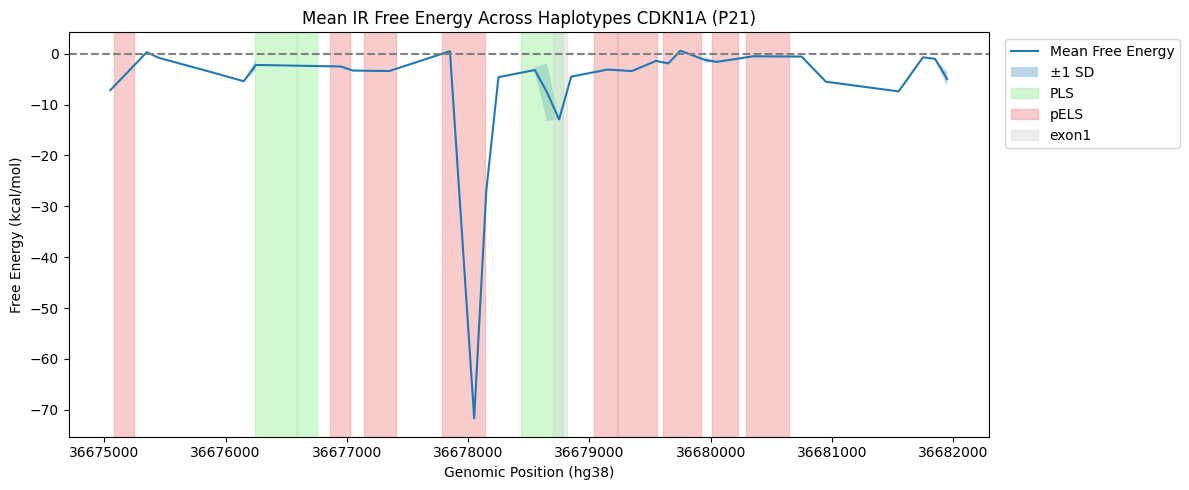

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import numpy as np

# === Region Settings ===
target_chr = "chr6"
target_start = 36675000
target_end = 36682000
bin_size = 100

# === Annotation ===
annotation_file = "/home/alextu/scratch/Biological regions  aggregate  NCBI RefSeq Annotation GCF_000001405.40-RS_2024_08.BED"
annotations = pd.read_csv(annotation_file, sep="\t", header=None,
                          names=["chrom", "start", "end", "feature", "score", "strand"])
annotations = annotations[
    (annotations["chrom"] == "NC_000006.12") &
    (annotations["end"] >= target_start) &
    (annotations["start"] <= target_end) &
    (annotations["feature"].isin(["pELS", "PLS", "exon1"]))
].copy()


# === Bin region ===
bins = pd.IntervalIndex.from_breaks(np.arange(target_start, target_end + bin_size, bin_size))
binned_data = pd.DataFrame({'bin': bins}).set_index('bin')

# === Read and aggregate all files ===
max_files = 3
all_files = sorted(glob.glob("/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/*_IR_free_energy.tsv"))[:max_files]

for file in all_files:
    print("processing", file)
    df = pd.read_csv(file, sep="\t")
    df["chrom"] = df["Sequence_name"].str.extract(r"\|(chr\d+)")
    df = df[(df["chrom"] == target_chr) & (df["Start"] >= target_start) & (df["Stop"] <= target_end)].copy()

    if df.empty:
        continue

    # Assign each IR to a bin by its midpoint
    df["mid"] = (df["Start"] + df["Stop"]) // 2
    df["bin"] = pd.cut(df["mid"], bins)

    # Aggregate free energy per bin
    bin_means = df.groupby("bin", observed=False)["Free_Energy"].mean()
    binned_data[file] = bin_means

# === Final aggregation across haplotypes ===
binned_data["mean_FE"] = binned_data.mean(axis=1, skipna=True)
binned_data["std_FE"] = binned_data.std(axis=1, skipna=True)
binned_data["bin_center"] = binned_data.index.mid

# === Plot ===
plt.figure(figsize=(12, 5))
ax = plt.gca()

# Mean free energy line
sns.lineplot(x="bin_center", y="mean_FE", data=binned_data, label="Mean Free Energy", ax=ax)

# Shaded area for variability
ax.fill_between(binned_data["bin_center"], 
                binned_data["mean_FE"] - binned_data["std_FE"], 
                binned_data["mean_FE"] + binned_data["std_FE"], 
                alpha=0.3, label="±1 SD")

feature_colors = {
    "PLS": "lightgreen",
    "pELS": "lightcoral",
    "dELS": "lightblue",
    "exon1": "lightgrey",
    "exon2": "lightgrey",
    "exon3": "lightgrey"
}

for _, row in annotations.iterrows():
    color = feature_colors.get(row["feature"], "gray")
    ax.axvspan(row["start"], row["end"], color=color, alpha=0.4, label=row["feature"])

# Legend cleanup
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_title("Mean IR Free Energy Across Haplotypes CDKN1A (P21)")
ax.set_xlabel("Genomic Position (hg38)")
ax.set_ylabel("Free Energy (kcal/mol)")
ax.axhline(0, color="gray", linestyle="--")
ax.ticklabel_format(style='plain', axis='x')
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.savefig("mean_p21_IR_density_across_haplotypes.png", dpi=300)
plt.show()

processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap1_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap2_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00171_hap1_IR_free_energy.tsv


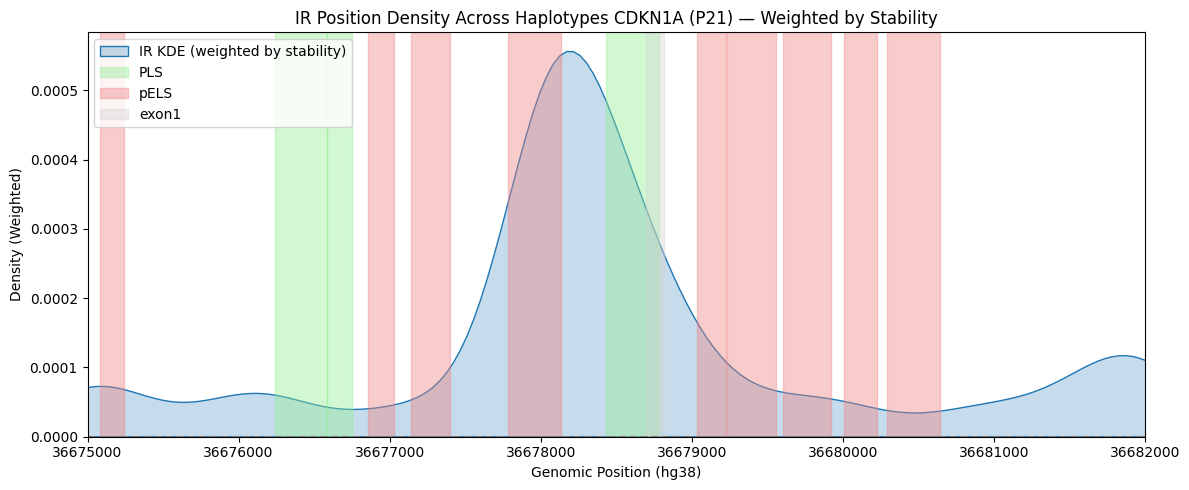

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np

# === Region Settings ===
target_chr = "chr6"
target_start = 36675000
target_end = 36682000

# === Annotation ===
annotation_file = "/home/alextu/scratch/Biological regions  aggregate  NCBI RefSeq Annotation GCF_000001405.40-RS_2024_08.BED"
annotations = pd.read_csv(annotation_file, sep="\t", header=None,
                          names=["chrom", "start", "end", "feature", "score", "strand"])
annotations = annotations[
    (annotations["chrom"] == "NC_000006.12") &
    (annotations["end"] >= target_start) &
    (annotations["start"] <= target_end) &
    (annotations["feature"].isin(["pELS", "PLS", "exon1"]))
].copy()

# === Collect all IR midpoints and stability weights across haplotypes ===
all_files = sorted(glob.glob("/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/*_IR_free_energy.tsv"))[:3]
midpoints = []
weights = []

for file in all_files:
    print("processing", file)
    df = pd.read_csv(file, sep="\t")
    df["chrom"] = df["Sequence_name"].str.extract(r"\|(chr\d+)")
    df = df[(df["chrom"] == target_chr) & (df["Start"] >= target_start) & (df["Stop"] <= target_end)]

    if not df.empty:
        mids = ((df["Start"] + df["Stop"]) // 2).tolist()
        fe_values = df["Free_Energy"].tolist()

        midpoints.extend(mids)
        weights.extend([abs(fe) for fe in fe_values])  # positive, stability-weighted

# === KDE Plot ===
plt.figure(figsize=(12, 5))
ax = plt.gca()

sns.kdeplot(x=midpoints, weights=weights, bw_adjust=0.3, fill=True, ax=ax, label="IR KDE (weighted by stability)")

# === Annotations ===
feature_colors = {
    "PLS": "lightgreen",
    "pELS": "lightcoral",
    "exon1": "lightgrey",
    "exon2": "lightgrey",
    "exon3": "lightgrey"
}

for _, row in annotations.iterrows():
    color = feature_colors.get(row["feature"], "gray")
    ax.axvspan(row["start"], row["end"], color=color, alpha=0.4, label=row["feature"])

# === Legend and styling ===
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left')

ax.set_title("IR Position Density Across Haplotypes CDKN1A (P21) — Weighted by Stability")
ax.set_xlabel("Genomic Position (hg38)")
ax.set_ylabel("Density (Weighted)")
ax.axhline(0, color="gray", linestyle="--")
ax.set_xlim(target_start, target_end)
ax.ticklabel_format(style='plain', axis='x')
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.savefig("kde_p21_IR_density_weighted_by_stability.png", dpi=300)
plt.show()

processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap1_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap2_IR_free_energy.tsv
processing /home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00171_hap1_IR_free_energy.tsv


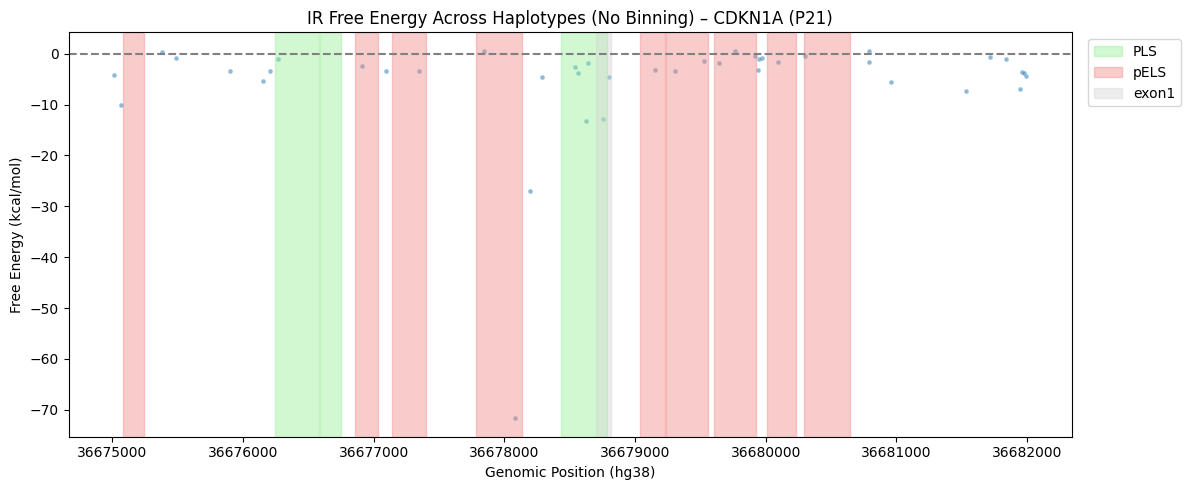

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# === Region Settings ===
target_chr = "chr6"
target_start = 36675000
target_end = 36682000

# === Annotation ===
annotation_file = "/home/alextu/scratch/Biological regions  aggregate  NCBI RefSeq Annotation GCF_000001405.40-RS_2024_08.BED"
annotations = pd.read_csv(annotation_file, sep="\t", header=None,
                          names=["chrom", "start", "end", "feature", "score", "strand"])
annotations = annotations[
    (annotations["chrom"] == "NC_000006.12") &
    (annotations["end"] >= target_start) &
    (annotations["start"] <= target_end) &
    (annotations["feature"].isin(["pELS", "PLS", "exon1"]))
].copy()


# === Read and aggregate all files ===
max_files = 3
all_files = sorted(glob.glob("/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/*_IR_free_energy.tsv"))[:max_files]

all_data = []

for file in all_files:
    print("processing", file)
    df = pd.read_csv(file, sep="\t")
    df["chrom"] = df["Sequence_name"].str.extract(r"\|(chr\d+)")
    df = df[(df["chrom"] == target_chr) & (df["Start"] >= target_start) & (df["Stop"] <= target_end)].copy()

    if df.empty:
        continue

    df["mid"] = (df["Start"] + df["Stop"]) // 2
    #df["mid"] = df["Stop"]
    df["sample"] = os.path.basename(file)
    all_data.append(df[["mid", "Free_Energy", "sample"]])

if not all_data:
    raise ValueError("No data found in selected region.")

plot_data = pd.concat(all_data, ignore_index=True)

# === Plot ===
plt.figure(figsize=(12, 5))
ax = plt.gca()

# Scatter raw points (one point per IR midpoint)
sns.scatterplot(data=plot_data, x="mid", y="Free_Energy", alpha=0.5, s=12, ax=ax)

# === Annotations ===
feature_colors = {
    "PLS": "lightgreen",
    "pELS": "lightcoral",
    "dELS": "lightblue",
    "exon1": "lightgrey",
    "exon2": "lightgrey",
    "exon3": "lightgrey"
}

for _, row in annotations.iterrows():
    color = feature_colors.get(row["feature"], "gray")
    ax.axvspan(row["start"], row["end"], color=color, alpha=0.4, label=row["feature"])

# === Legend cleanup ===
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.01, 1), loc='upper left')

ax.set_title("IR Free Energy Across Haplotypes (No Binning) – CDKN1A (P21)")
ax.set_xlabel("Genomic Position (hg38)")
ax.set_ylabel("Free Energy (kcal/mol)")
ax.axhline(0, color="gray", linestyle="--")
ax.ticklabel_format(style='plain', axis='x')
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.tight_layout()
plt.savefig("raw_points_p21_IR_FE_no_binning.png", dpi=300)
plt.show()

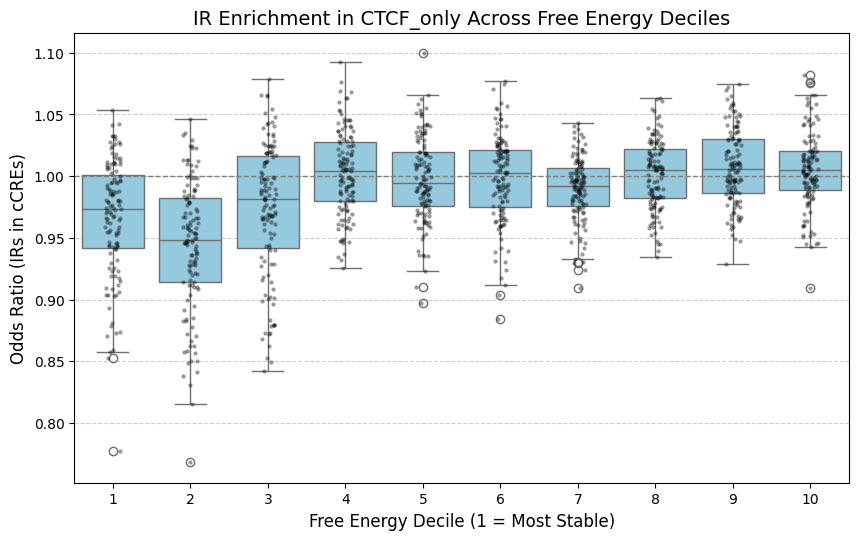

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load results CSV ===
results_path = "/home/alextu/scratch/cCRE_analysis/final_decilewise_enrichment_IR_CTCF_only_negative_only.csv"
df = pd.read_csv(results_path)
df["decile"] = df["decile"].astype(int)

# === 2. Setup figure ===
plt.figure(figsize=(10, 6))
# Do NOT call sns.set() due to matplotlib.colors error

# === 3. Boxplot: Odds Ratio per Decile (across haplotypes) ===
sns.boxplot(
    data=df,
    x="decile",
    y="odds_ratio",
    color="skyblue",
    linewidth=1
)

# Optional: Add individual data points on top
sns.stripplot(
    data=df,
    x="decile",
    y="odds_ratio",
    color="black",
    alpha=0.4,
    jitter=True,
    size=3
)

# === 4. Styling ===
plt.xlabel("Free Energy Decile (1 = Most Stable)", fontsize=12)
plt.ylabel("Odds Ratio (IRs in cCREs)", fontsize=12)
plt.title("IR Enrichment in CTCF_only Across Free Energy Deciles", fontsize=14)
plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xticks(range(0, 10), labels=[str(i + 1) for i in range(10)])
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

# Fix layout by using subplots_adjust instead of tight_layout
plt.subplots_adjust(bottom=0.15, top=0.9)
plt.show()